###The Stationarity vs. Memory Dilemma



In order to perform inferential analyses, researchers need to work with invariant processes,such as

* returns on prices (or changes in log-prices)
* changes in yield
* changes in volatility

These operations make the series stationary, at the expense of removing all memory from the
original series.

Memory is the basis for the model’s predictive power.
* For example, equilibrium (stationary) models need some memory to assess how far the price process has
drifted away from the long-term expected value in order to generate a forecast.

The dilemma is
* returns are stationary however memory-less; and
* prices have memory however they are non-stationary.








=------------------
Lets think we have an option to give only one feature to the model.
Either we can give the price series..
Or we can give the returns series..
The problem with price series is, ml models does not fit well with non stationary data..

Returns are stationary but it loses its predictive power...so we cant make good ml models from this data..

------------------------





###The Optimal Stationary-Memory Trade Off


*Question: What is the minimum amount of differentiation that makes a price series stationary
while preserving as much memory as possible?*


**Answer: We would like to generalize the notion of returns to consider stationary series where not all memory is erased.
• Under this framework, returns are just one kind of (and in most cases suboptimal) price
transformation among many other possible.**




here, prices are not directly used since there is no stationarity...so prices need to be transformed(in such a way, there is less memory loss)...the returns are just one form of price transformation avaialble..


1) what degree of memory loss does transformation of prices to returns results in?

2) if we differentiate the price series by a factor of 1, dp/dt , we achieve stationarity at the cost of losing all memory of original price series.

so, can we differentiate or transform price series to achieve stationarity without losing all memory?

**Fractional (non-integer) differentiation will be explored in this notebook.**

* Green line: E-mini S&P 500 futures trade bars of size
1E4

* Blue line: Fractionally differentiated (𝑑 = .4)
* Over a short time span, it resembles returns
* Over a longer time span, it resembles price levels




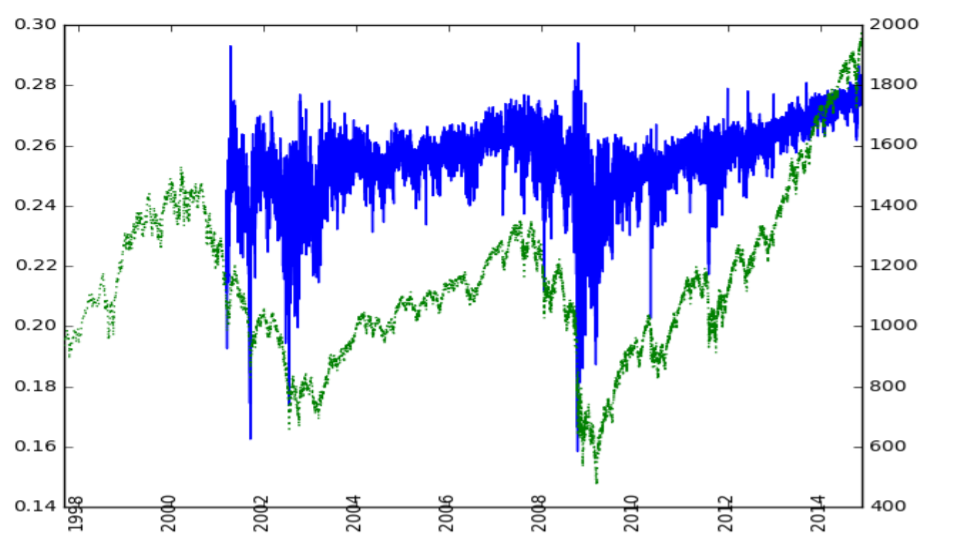

The green plot is S&P500 futures dollar bars of size $10000

The S&P500 futures dollar bars are differentiated by 0.4 to get blue line



What is stationarity>?

Statistical stationarity: A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.

Note:

(If the series has a stable long-run trend and tends to revert to the trend line following a disturbance, it may be possible to stationarize it by de-trending (e.g., by fitting a trend line and subtracting it out prior to fitting a model, or else by including the time index as an independent variable in a regression or ARIMA model), perhaps in conjunction with logging or deflating.   Such a series is said to be trend-stationary)

Example 1: E-mini S&P 500 Futures
` On the x-axis, the d value used to generate the series on which the ADF stat was computed.
* On the left y-axis, the correlation between the original series (𝑑 = 0) and the differentiated
series at various d values.
* On the right y-axis, ADF stats computed on log prices.


-----------------------------------------------------
The original series (𝑑 = 0) has an ADF stat of -
0.3387, while the returns series (𝑑 = 1) has an
ADF stat of -46.9114.


At a 95% confidence level, the test’s critical
value is -2.8623.

The ADF stat crosses that threshold in the
vicinity of 𝑑 = 0.35, where correlation is still
very high (0.995).

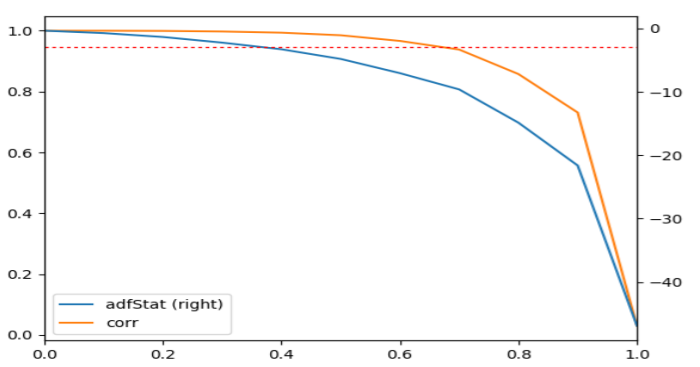

**ADF -Augmented Dickey–Fuller test**


The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root(trend-stationarity) at some level of confidence.













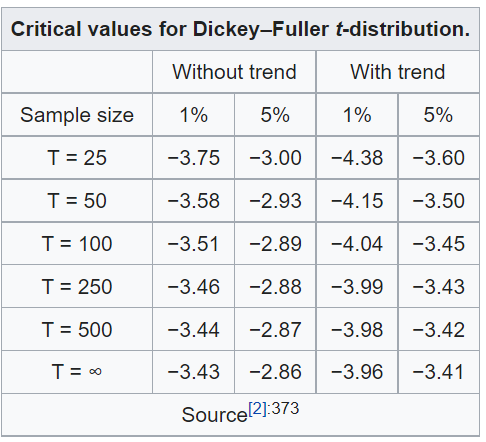

Lets apply the above concepts to close prices of Nifty 50 15 min time bars 

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [61]:
#@title Fractional Differenciation Functions
#Fractional Differenciation Codes
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


def getWeights(d, size):
    # thresh > 0 drops insignificant weights
    w = [1.0]
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def fracDiff(series, d, thres=0.01):
    '''
    Increasing width window, with treatment of NaNs
    Note: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessarily bounded [0,1]
    '''
    # 1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    # 2) Determine initial calcs to be skipped based on the weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > thres].shape[0]
    # 3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series(index=series.index) # bug in the original code
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]):
                continue # exclude NAs
            a = w[-(iloc + 1):, :].T
            b = seriesF.loc[:loc]
            df_[loc] = np.dot(a, b)[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df


def getWeights_FFD(d, thres):
    w, k = [1.0], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)


def fracDiff_FFD(series, d, thres=1e-5):
    # Constant with window (new solution)
    w =  getWeights_FFD(d, thres)
    width, df = len(w) - 1, {}
    
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series(index=series.index)
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue # exclude NAs
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df


def fracDiff_FFD_1feature(series, d, thres=1e-5):
    # Constant with window (new solution)
    w =  getWeights_FFD(d, thres)
    width, df = len(w) - 1, {}
    
    
    seriesF, df_ = series.fillna(method='ffill').dropna(), pd.Series(index=series.index)
    for iloc1 in range(width, seriesF.shape[0]):
        loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
        if not np.isfinite(series.loc[loc1]):
            continue # exclude NAs
        df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])
    df = df_.copy(deep=True)
    
    return df

def findMinFFD(series):
    
    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    
    for d in np.linspace(0, 1, 21):
        
      df1 = series.resample('1D').last() # downcast to daily obs
      df2 = fracDiff_FFD_1feature(df1, d, thres=0.01)
      corr = np.corrcoef(df1.loc[df2.index], df2)[0, 1]
      df2 = df2.dropna()
      df2 = adfuller(df2, maxlag=1, regression='c', autolag=None)

      if df2[1] < 0.05:
        return np.round(d,2)
        break





read nifty 50 15 min data from csv

In [77]:

prices = pd.read_csv(root + "Feature Engineering/Fractional Differentiation/nifty_50_prices_15min.csv")
prices.date = pd.to_datetime(prices.date)
prices = prices.set_index('date')


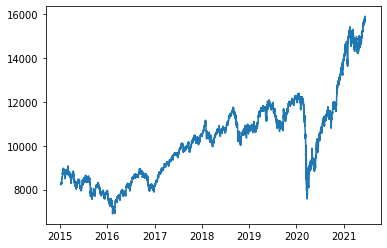

In [63]:
closes = prices.Close
plt.plot(prices.Close)

In [67]:
adfuller(closes)

(0.30296959528295964,
 0.977480320151765,
 51,
 39535,
 {'1%': -3.4305154160778204,
  '10%': -2.5668089141533064,
  '5%': -2.8616131100827267},
 354441.72173311346)

In [65]:
min_d = findMinFFD(prices.Close)
min_d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


0.45

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


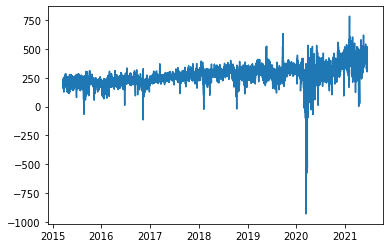

In [66]:
closes_frac_diff = fracDiff_FFD_1feature(prices.Close,min_d)
plt.plot(closes_frac_diff)

In [69]:
adfuller(closes_frac_diff.dropna())

(-5.980968980236878,
 1.8389613633815886e-07,
 50,
 38374,
 {'1%': -3.43052042105294,
  '10%': -2.566810091551587,
  '5%': -2.8616153221025256},
 344603.607069949)

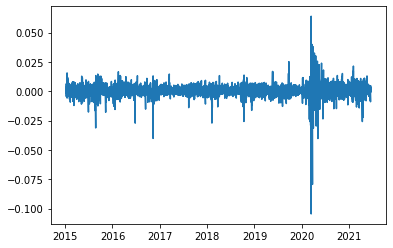

In [70]:
returns = prices.Close.pct_change()
plt.plot(returns)

In [71]:
adfuller(returns.dropna())

(-25.294912611037034,
 0.0,
 54,
 39531,
 {'1%': -3.4305154328167666,
  '10%': -2.5668089180910716,
  '5%': -2.861613117480748},
 -374135.35248406534)

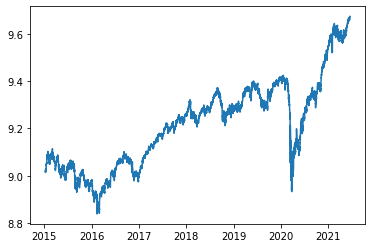

In [72]:
log_close = np.log(prices.Close)
plt.plot(log_close)

In [73]:
adfuller(log_close.dropna())

(-0.2535862175396029,
 0.9318255242257402,
 51,
 39535,
 {'1%': -3.4305154160778204,
  '10%': -2.5668089141533064,
  '5%': -2.8616131100827267},
 -373668.35293449135)

In [74]:
min_d_log = findMinFFD(np.log(prices.Close))
min_d_log

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


0.4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


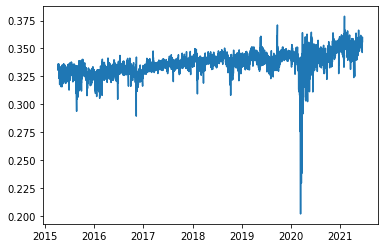

In [51]:
closes_log_fracdiff = fracDiff_FFD_1feature(np.log(prices.Close),min_d_log)
plt.plot(closes_log_fracdiff)

In [76]:
adfuller(closes_log_fracdiff.dropna())

(-5.187330143125148,
 9.33111845405673e-06,
 53,
 38076,
 {'1%': -3.4305217549351275,
  '10%': -2.566810405341252,
  '5%': -2.861615911630063},
 -359399.46338408743)

References:- 


https://www.amazon.in/Advances-Financial-Machine-Learning-Marcos/dp/1119482089

https://github.com/boyboi86/AFML/

https://www.ma.imperial.ac.uk/~ejm/M3S8/Problems/hosking81.pdf



